In [1]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from sympy import  Interval, Symbol, solveset 

# New Section

<p align:"center"><h2>Goldbeter’s circadian oscillator model</h2></p>

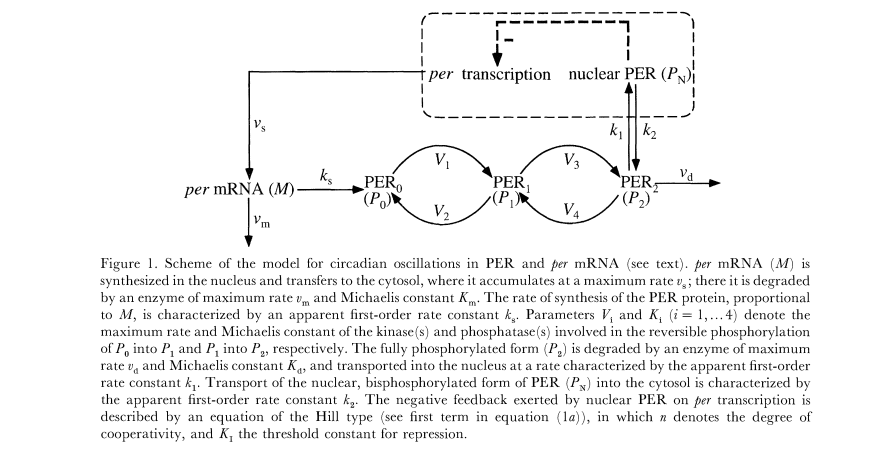

In [2]:
# slide 5 (page 216 - fig 7.19)
# https://www.math.uwaterloo.ca/~bingalls/MMSB/Code/matlab/circadian_rhythm.m
# https://pubmed.ncbi.nlm.nih.gov/8587874/ (paper of Goldbeter’s circadian oscillator model)
def model_S4(y, t , vd=0.95):
    # parameter values
    vs=0.76;
    vm=0.65;
    ks=0.38;
    kt1=1.9;
    kt2=1.3;
    v1=3.2;
    v2=1.58;
    v3=5;
    v4=2.5;
    k1=1;
    k2=1;
    k3=2;
    k4=2;
    ki=1;
    km1=0.5;
    kd=0.2;
    n=4;
    # model dynamics
    # y[0], y[1], y[2], y[3], y[4] are initial concentration of M, P0, P1, P2, PN (The species are described below.) 
    M = y[0]
    P0 = y[1]
    P1 = y[2]
    P2 = y[3]
    PN = y[4]
    # description of Goldbeter’s circadian oscillator model (see page 215 - fig 7.18):
    # The per gene is transcribed in the nucleus; per mRNA (M) is exported to the cytosol, where is it translated and is subject to degradation.
    # PER protein (P0) is activated by two reversible rounds of phosphorylation. 
    # Active PER (P2) is subject to degradation, and can cross the nuclear membrane. Once in the nucleus, 
    # PER(PN ) represses transcription of the per gene. Delay oscillations arise from the combination of autoinhibitory 
    # feedback, nonlinear repression kinetics, and delay. 
    dMdt  = vs/(1+np.power((PN/ki),n)) - (vm*M)/(km1+M)
    dP0dt = ks*M - (v1*P0)/(k1+P0) + (v2*P1)/(k2 + P1)
    dP1dt = (v1*P0)/(k1+P0) - (v2*P1)/(k2 + P1) - (v3*P1)/(k3+P1) + (v4*P2)/(k4+P2)
    dP2dt = (v3*P1)/(k3+P1) - (v4*P2)/(k4+P2)  - kt1*P2 + kt2*PN - (vd*P2)/(kd+P2)
    dPNdt = kt1*P2 - kt2*PN
    dydt = [dMdt,dP0dt,dP1dt,dP2dt,dPNdt]
    return dydt

In [3]:
# set initial condition:
# Initial concentration of Species M, P0, P1, P2, PN
y0 = [1,1,0,0,0]
# time points
# np.linspace(starting value of the sequence, end value of the sequence, Number of samples to generate)
t = np.linspace(-50,200,300)
# call odeint function
# y = odeint(model, y0, t)
result = odeint(model_S4,y0,t)
# The values of species M have been stored in : result[:,0]
# The values of species P0 have been stored in : result[:,1]
# The values of species P1 have been stored in : result[:,2]
# The values of species P2 have been stored in : result[:,3]
# The values of species PN have been stored in : result[:,4]

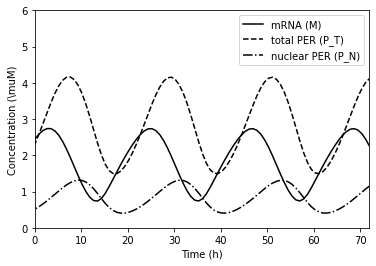

In [4]:
# generate figure 7.19A
plt.plot(t,result[:,0],'k',label='mRNA (M)')
# total PER protein (pT = p0 + p1 + p2 + pN )
plt.plot(t,result[:,1]+result[:,2]+result[:,3]+result[:,4],'k--',label='total PER (P_T)')
plt.plot(t,result[:,4],'k-.',label='nuclear PER (P_N)')
plt.ylabel('Concentration (\muM)')
plt.xlabel('Time (h)')
plt.legend()
plt.xlim([0, 72])
plt.ylim([0, 6])
plt.show()

In [5]:
# Goal: Show the effect of changes in the maximal PER degradation rate (vd) on the oscillation period. 
# Within the range over which oscillations occur, the period ranges from about 20 to more than 60 hours.
# vd: maximal PER degradation rate 

# choose a mesh of vd values
N=15;

peakepsilon = 0.05
vd_values = []
period = []

# over the mesh, determine the period of oscillation
for i in range(1,N+1):
    vd=0.5 + (2.55 - 0.5)*(i-1)/(N-1);
    vd_values.append(vd)
    # run simulation
    result = odeint(model_S4,y0,t,args=(vd,))
    # determine peak for local maxima
    # usage of argrelextrema function: Finding local maxima (np.greater) 
    inds = argrelextrema(result[:,0], np.greater)[0]
    maxpeak=max(result[range(int(np.floor(0.8*len(t))),len(t)),0])

    # determine peak-to-peak time interval 
    flag1=0; 
    n1=0;
    while flag1==0:
        index_of_last_peak=inds[inds.shape[0]-n1-1]
        if maxpeak-result[index_of_last_peak,0]<peakepsilon:
            flag1=1
        else:
            n1=n1+1
    
    flag2=0;
    n2=n1+1;
    while flag2==0:
        index_of_secondlastpeak=inds[inds.shape[0]-n2-1]
        if maxpeak-result[index_of_secondlastpeak,0]<peakepsilon:
            flag2=1
        else:
            n2=n2+1
    period.append(t[index_of_last_peak]-t[index_of_secondlastpeak])

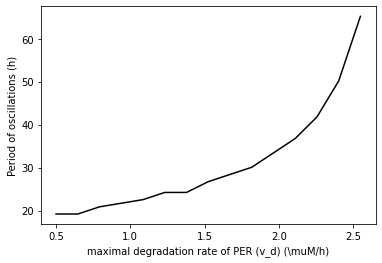

In [6]:
# generate figure 7.19B
plt.plot(vd_values, period, 'k')
plt.xlabel('maximal degradation rate of PER (v_d) (\muM/h)')
plt.ylabel('Period of oscillations (h)')
plt.show()

In [7]:
# Slide 7 (page 210 - fig 7.13, fig 7.14, fig 7.15)
def model_S7(y, t , i1=0 , i2=0 , a1 = 3 , a2 = 2.5 , beta=4 , gamma=4):
    # parameters:
    # α1 and α2 are their maximal expression rates
    # beta and gamma indicate the degree of nonlinearity (i.e. cooperativity) in the repression mechanisms
    # i1, i2 characterize the two inducers. 
    # Dilution is considered to be dominant over degradation,so the decay rates are identical.
    # model dynamics
    # Rep1 and Rep2 are the concentrations of the two proteins
    # y[0] , y[1] are initial concentration of Rep1 & Rep2
    Rep1 = y[0]
    Rep2 = y[1]
    dRep1dt  = a1/(1+(Rep2/(1+i2))**beta) - Rep1
    dRep2dt = a2/(1+(Rep1/(1+i1))**gamma) - Rep2
    dydt = [dRep1dt,dRep2dt]
    return dydt

In [8]:
# set initial condition:
# Initial concentration of Species Rep1 , Rep2
y0 = [0.075 , 2.5]
#time-varying input profile for Figure 7.13
t1 = np.linspace(0,10)
t2 = np.linspace(10,20)
t3 = np.linspace(20,30)
t4 = np.linspace(30,40)
t5 = np.linspace(40,50)

# run simulation
# parameters:
# i1, i2 characterize the two inducers. 
# t1
i1 = 0
i2 = 0
# call odeint function
# y = odeint(model, y0, t)
result1 = odeint(model_S7,y0,t1,args=( i1 , i2 ,))
# t2
y0 = [result1[-1,0] , result1[-1,1]]
i1 = 0
i2 = 10
# call odeint function
# y = odeint(model, y0, t)
# note that: the initial concentration of Rep1 and Rep2 in the t2 time range is equal to 
# the final concentration of Rep1 and Rep2 in the previous time range (t1)
result2 = odeint(model_S7,y0,t2,args=( i1 , i2 ,))
# t3
y0 = [result2[-1,0] , result2[-1,1]]
i1 = 0
i2 = 0
# call odeint function
# y = odeint(model, y0, t)
# note that: the initial concentration of Rep1 and Rep2 in the t3 time range is equal to 
# the final concentration of Rep1 and Rep2 in the previous time range (t2)
result3 = odeint(model_S7,y0,t3,args=( i1 , i2 ,))    
# t4
y0 = [result3[-1,0] , result3[-1,1]]
i1 = 10
i2 = 0
# call odeint function
# y = odeint(model, y0, t)
# note that: the initial concentration of Rep1 and Rep2 in the t4 time range is equal to 
# the final concentration of Rep1 and Rep2 in the previous time range (t3)
result4 = odeint(model_S7,y0,t4,args=( i1 , i2 ,))    
# t5
y0 = [result4[-1,0] , result4[-1,1]]
i1 = 0
i2 = 0
# call odeint function
# y = odeint(model, y0, t)
# note that: the initial concentration of Rep1 and Rep2 in the t5 time range is equal to 
# the final concentration of Rep1 and Rep2 in the previous time range (t4)
result5 = odeint(model_S7,y0,t5,args=( i1 , i2 ,)) 

# concatinate times and cocentrations
t = np.concatenate([t1,t2,t3,t4,t5])
y1 = np.concatenate([result1[:,0],result2[:,0],result3[:,0],result4[:,0],result5[:,0]])
y2 = np.concatenate([result1[:,1],result2[:,1],result3[:,1],result4[:,1],result5[:,1]])


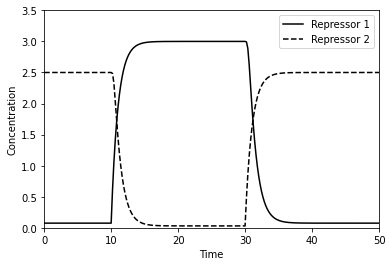

In [9]:
# generate figure 7.13
plt.plot(t,y1,'k',label='Repressor 1')
plt.plot(t,y2,'k--',label='Repressor 2')
plt.ylabel('Concentration')
plt.xlabel('Time')
plt.legend()
plt.xlim([0, 50])
plt.ylim([0, 3.5])
plt.show()

In [10]:
# generate phaseportraits
# Simulations for Figure 7.14A
# https://www.math.uwaterloo.ca/~bingalls/MMSB/Code/matlab/Collins_toggle_switch.m
# time points
# np.linspace(starting value of the sequence, end value of the sequence, Number of samples to generate)
t = np.linspace(0,50,200)
# call odeint function with different initial concentrations of Rep1 & Rep2
# y = odeint(model, y0, t)
result1 = odeint(model_S7,[0,0],t) 
result2 = odeint(model_S7,[5,0],t) 
result3 = odeint(model_S7,[1,0],t) 
result4 = odeint(model_S7,[1.5,0],t)    
result5 = odeint(model_S7,[2,0],t)   
result6 = odeint(model_S7,[2.5,0],t) 
result7 = odeint(model_S7,[3,0],t) 
result8 = odeint(model_S7,[3.5,0],t) 
result9 = odeint(model_S7,[3.5,0.5],t)
result10 = odeint(model_S7,[3.5,1],t) 
result11 = odeint(model_S7,[3.5,1.5],t) 
result12 = odeint(model_S7,[3.5,2],t) 
result13 = odeint(model_S7,[3.5,2.5],t) 
result14 = odeint(model_S7,[3.5,3],t) 
result15 = odeint(model_S7,[3.5,3.5],t) 
result16 = odeint(model_S7,[3,3.5],t)
result17 = odeint(model_S7,[2.5,3.5],t)
result18 = odeint(model_S7,[2,3.5],t)
result19 = odeint(model_S7,[1.5,3.5],t)
result20 = odeint(model_S7,[1,3.5],t)
result21 = odeint(model_S7,[0.5,3.5],t)
result22 = odeint(model_S7,[0,3.5],t)
result23 = odeint(model_S7,[0,3],t)
result24 = odeint(model_S7,[0,2.5],t)
result25 = odeint(model_S7,[0,2],t)
result26 = odeint(model_S7,[0,1.5],t)
result27 = odeint(model_S7,[0,1],t)
result28 = odeint(model_S7,[0,0.5],t)

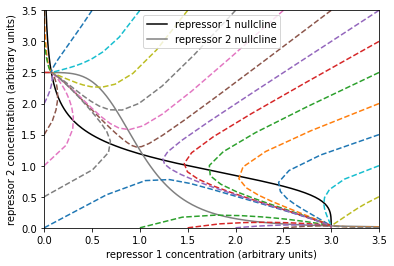

In [11]:
# plot resultimulation traceresult
# time points
# np.linspace(starting value of the sequence, end value of the sequence, Number of samples to generate)
p2 = np.linspace(0,3.5,200)
# assign parameter values
# α1 and α2 are their maximal expression rates
# beta and gamma indicate the degree of nonlinearity (i.e. cooperativity) in the repression mechanisms
# i1, i2 characterize the two inducers. 
a1=3
beta=4
plt.plot(a1/(1+(p2/(1+i2))**beta),p2,color = 'black' , label = "repressor 1 nullcline")
p1 = np.linspace(0,3.5,200)
i2=0
a2=2.5
gamma=4
i1=0
plt.plot(p1 , a2/(1+(p1/(1+i1))**gamma) ,color = 'gray' , label = "repressor 2 nullcline")
plt.plot(result1[:,0], result1[:,1],'--')
plt.plot(result2[:,0], result2[:,1],'--')
plt.plot(result3[:,0], result3[:,1],'--')
plt.plot(result4[:,0], result4[:,1],'--')
plt.plot(result5[:,0], result5[:,1],'--')
plt.plot(result6[:,0], result6[:,1],'--')
plt.plot(result7[:,0], result7[:,1],'--')
plt.plot(result8[:,0], result8[:,1],'--')
plt.plot(result9[:,0], result9[:,1],'--')
plt.plot(result10[:,0], result10[:,1],'--')
plt.plot(result11[:,0], result11[:,1],'--')
plt.plot(result12[:,0], result12[:,1],'--')
plt.plot(result13[:,0], result13[:,1],'--')
plt.plot(result14[:,0], result14[:,1],'--')
plt.plot(result15[:,0], result15[:,1],'--')
plt.plot(result16[:,0], result16[:,1],'--')
plt.plot(result17[:,0], result17[:,1],'--')
plt.plot(result18[:,0], result18[:,1],'--')
plt.plot(result19[:,0], result19[:,1],'--')
plt.plot(result20[:,0], result20[:,1],'--')
plt.plot(result21[:,0], result21[:,1],'--')
plt.plot(result22[:,0], result22[:,1],'--')
plt.plot(result23[:,0], result23[:,1],'--')
plt.plot(result24[:,0], result24[:,1],'--')
plt.plot(result25[:,0], result25[:,1],'--')
plt.plot(result26[:,0], result26[:,1],'--')
plt.plot(result27[:,0], result27[:,1],'--')
plt.plot(result28[:,0], result28[:,1],'--')
plt.ylabel('repressor 2 concentration (arbitrary units)')
plt.xlabel('repressor 1 concentration (arbitrary units)')
plt.legend()
plt.xlim([0, 3.5])
plt.ylim([0, 3.5])
plt.show()

In [12]:
# generate phaseportraits
# Simulations for Figure 7.14B
# https://www.math.uwaterloo.ca/~bingalls/MMSB/Code/matlab/Collins_toggle_switch_induced.m
# parameters
# i1, i2 characterize the two inducers. 
i1=0
i2=10
# time points
# np.linspace(starting value of the sequence, end value of the sequence, Number of samples to generate)
t = np.linspace(0,50,200)
# call odeint function with different initial concentrations of Rep1 & Rep2
# y = odeint(model, y0, t)
result1 = odeint(model_S7,[0,0],t,args=( i1 , i2 ,)) 
result2 = odeint(model_S7,[1,0],t,args=( i1 , i2 ,)) 
result3 = odeint(model_S7,[2,0],t,args=( i1 , i2 ,)) 
result4 = odeint(model_S7,[3,0],t,args=( i1 , i2 ,))    
result5 = odeint(model_S7,[3.5,0],t,args=( i1 , i2 ,))   
result6 = odeint(model_S7,[3.5,0.5],t,args=( i1 , i2 ,)) 
result7 = odeint(model_S7,[3.5,1.5],t,args=( i1 , i2 ,)) 
result8 = odeint(model_S7,[3.5,2.5],t,args=( i1 , i2 ,)) 
result9 = odeint(model_S7,[3.5,3.5],t,args=( i1 , i2 ,))
result10 = odeint(model_S7,[3,3.5],t,args=( i1 , i2 ,)) 
result11 = odeint(model_S7,[2,3.5],t,args=( i1 , i2 ,)) 
result12 = odeint(model_S7,[1,3.5],t,args=( i1 , i2 ,)) 
result13 = odeint(model_S7,[0,3],t,args=( i1 , i2 ,)) 
result14 = odeint(model_S7,[0,2],t,args=( i1 , i2 ,)) 
result15 = odeint(model_S7,[0,1],t,args=( i1 , i2 ,)) 

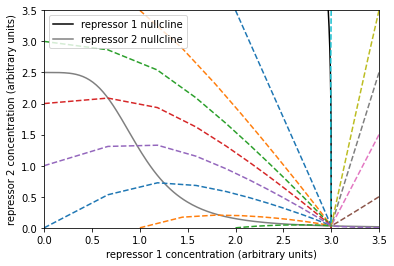

In [13]:
# plot resultimulation traceresult
# time points
# np.linspace(starting value of the sequence, end value of the sequence, Number of samples to generate)
p2 = np.linspace(0,3.5,200)
# assign parameter values
# α1 and α2 are their maximal expression rates
# beta and gamma indicate the degree of nonlinearity (i.e. cooperativity) in the repression mechanisms
# i1, i2 characterize the two inducers. 
a1=3
beta=4
plt.plot(a1/(1+(p2/(1+i2))**beta),p2,color = 'black' , label = "repressor 1 nullcline")
p1 = np.linspace(0,3.5,200)
i2=0
a2=2.5
gamma=4
i1=0
plt.plot(p1 , a2/(1+(p1/(1+i1))**gamma) ,color = 'gray' , label = "repressor 2 nullcline")
plt.plot(result1[:,0], result1[:,1],'--')
plt.plot(result2[:,0], result2[:,1],'--')
plt.plot(result3[:,0], result3[:,1],'--')
plt.plot(result4[:,0], result4[:,1],'--')
plt.plot(result5[:,0], result5[:,1],'--')
plt.plot(result6[:,0], result6[:,1],'--')
plt.plot(result7[:,0], result7[:,1],'--')
plt.plot(result8[:,0], result8[:,1],'--')
plt.plot(result9[:,0], result9[:,1],'--')
plt.plot(result10[:,0], result10[:,1],'--')
plt.plot(result11[:,0], result11[:,1],'--')
plt.plot(result12[:,0], result12[:,1],'--')
plt.plot(result13[:,0], result13[:,1],'--')
plt.plot(result14[:,0], result14[:,1],'--')
plt.plot(result15[:,0], result15[:,1],'--')
plt.ylabel('repressor 2 concentration (arbitrary units)')
plt.xlabel('repressor 1 concentration (arbitrary units)')
plt.legend()
plt.xlim([0, 3.5])
plt.ylim([0, 3.5])
plt.show()

In [14]:
def stability(beta , gamma):
  # parameters
  # beta and gamma indicate the degree of nonlinearity (i.e. cooperativity) in the repression mechanisms
  # set mesh size.  N=100 in the figure in the text, but that takes a long time to run.
  N=8
  # Three cases are considered: for the three values of beta, gamma
  t = np.linspace(0,2000)
  tolgrid= []
  for i in range(0,N):
      tolgrid.append([])
      for j in range(0,N):
        # sweep logarithmically through a1-a2 space.
        a1=np.exp(0+6*(i+1)/N)
        a2=np.exp(0+6*(j+1)/N)
        # Run simulations from low p1/high p2 and low p2/high p1
        result1 = odeint(model_S7,[100,0],t,args=( i1 , i2 ,a1, a2, beta, gamma,)) 
        result2 = odeint(model_S7,[0,100],t,args=( i1 , i2 ,a1, a2, beta, gamma,)) 
        # record the difference in s1 at steady state
        grid=np.abs(result1[-1,0]-result2[-1,0]);
        if grid<0.001:  # if the two simulations come to the same point
          try:
            tolgrid[i][j] = 0     # tolgrid is set to zero if the difference is negligible
          except: 
            tolgrid[-1].append(0)     # tolgrid is set to zero if the difference is negligible
        else:
            try:
                tolgrid[i][j] = grid #otherwise, the difference is recorded.
            except:
                tolgrid[-1].append(grid) #otherwise, the difference is recorded.

  # For each x-coordinate (i.e. a2), determine the y-coordinate (i.e. a1) at which bistability
  # begins
  xcurve=[[],[]];
  for xi in range(0,N):
      try:
        xcurve[0][xi]=xi
      except: 
        xcurve[0].append(xi)
      yi=0;
      while (yi<N) and (tolgrid[xi][yi]==0):
          yi=yi+1
      try:
        xcurve[1][xi] = yi
      except: 
        xcurve[1].append(yi)

  # For each y-coordinate (i.e. a1), determine the x-coordinate (i.e. a2) at which bistability
  # begins
  ycurve=[[],[]];

  for yi in range(0,N):
      try:
        ycurve[0][yi] = yi
      except:   
        ycurve[0].append(yi)
      xi=0
      while (xi<N) and (tolgrid[xi][yi]==0):
          xi=xi+1
      try:
        ycurve[1][yi] = xi
      except:
        ycurve[1].append(xi)
  return xcurve , ycurve

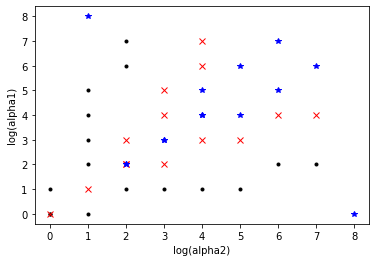

In [15]:
# Generate Figure 7.15 (slide 8)
# This is a "brute force" parameter sweep
# parameters
# beta and gamma indicate the degree of nonlinearity (i.e. cooperativity) in the repression mechanisms

# Case 1
beta=4
gamma=4
xcurve1 , ycurve1 = stability(beta , gamma)
# plot the resulting points in Figure 7.15
plt.plot(xcurve1[0], xcurve1[1], 'k.')
plt.plot(ycurve1[1], ycurve1[0], 'k.')

# Case 2
beta=2
gamma=2
xcurve2 , ycurve2 = stability(beta , gamma)
i=0
while xcurve2[i][1]==N-1:
    i=i+1;
xcurve2[0].pop(i)
xcurve2[1].pop(i)
i=1;
while ycurve2[i][1]==N-1:
    i=i+1;
ycurve2[0].pop(i)
ycurve2[1].pop(i)
# plot the resulting points in Figure 7.15
plt.plot(xcurve2[0], xcurve2[1], 'rx')
plt.plot(ycurve2[1], ycurve2[0], 'rx')

# Case 3
beta=1.5
gamma=1.5
xcurve3 , ycurve3 = stability(beta , gamma)
i=0
while xcurve3[i][1]==N-1:
    i=i+1;
xcurve3[0].pop(i)
xcurve3[1].pop(i)
i=1;
while ycurve3[i][1]==N-1:
    i=i+1;
ycurve3[0].pop(i)
ycurve3[1].pop(i)
# plot the resulting points in Figure 7.15
plt.plot(xcurve3[0], xcurve3[1], 'b*')
plt.plot(ycurve3[1], ycurve3[0], 'b*')
plt.xlabel('log(alpha2)')
plt.ylabel('log(alpha1)')
plt.show()

In [16]:
# Slide 10 (page 220 - fig 7.23)
# https://www.math.uwaterloo.ca/~bingalls/MMSB/Code/matlab/genetic_relaxation_oscillator.m
# paper: https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.88.148101
def model_S10(y, t):
    # assign parameter values
    # alpha represents the degree to which the transcription rate is increased when a
    # CI dimer is bound to OR2,and s is the affinity for a CI dimer binding to OR2 relative to binding at OR1.
    alpha=11
    sigma=2
    gammax=0.2
    gammay=0.012
    ay=0.2
    # model dynamics
    # y[0] and y[1] are the initial concentration of x , y (x and y are the concentrations of the activator, X, and repressor, Y , respectively)
    x = y[0]
    y = y[1]
    # x and y are the concentrations of the activator, X, and repressor, Y , respectively
    dxdt= (1+x**2+alpha*sigma*x**4)/((1+x**2+sigma*x**4)*(1+y**4)) - gammax*x;
    dydt= ay*((1+x**2+alpha*sigma*x**4)/((1+x**2+sigma*x**4)*(1+y**4))) - gammay*y;
    dTotaldt = [dxdt,dydt]
    return dTotaldt

In [17]:
# set initial condition:
# Initial concentration of Species x , y
y0 = [0.3963,2.3346]
# time points
# np.linspace(starting value of the sequence, end value of the sequence, Number of samples to generate)
t = np.linspace(0,300,600)
# call odeint function
# y = odeint(model, y0, t)
result = odeint(model_S10,y0,t)

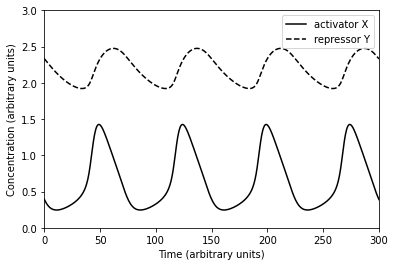

In [18]:
# generate figure 7.23A
plt.plot(t,result[:,0],'k',label='activator X')
plt.plot(t,result[:,1],'k--',label='repressor Y')
plt.ylabel('Concentration (arbitrary units)')
plt.xlabel('Time (arbitrary units)')
plt.legend()
plt.xlim([0, 300])
plt.ylim([0, 3])
plt.show()

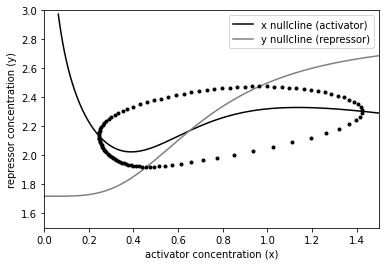

In [19]:
#produce figure 7.23B
#generate nullclines
# assign parameter values
alpha=11
sigma=2
gammax=0.2
gammay=0.012
ay=0.2
x = np.linspace(0,1.5,500)
# x nullcline (activator)
y_val_final = []
x_val_final = []
for x_val in x:
  y = Symbol('y')
  sol = solveset((1+x_val**2+alpha*sigma*x_val**4)/((1+x_val**2+sigma*x_val**4)*(1+y**4)) - gammax*x_val , domain=Interval(0, 3))
  if sol:
    x_val_final.append(x_val)
    y_val_final.append(sol.args[0] )
plt.plot(x_val_final,y_val_final,color = 'black' , label = 'x nullcline (activator)')

# y nullcline (repressor)
y_val_final = []
x_val_final = []
for x_val in x:
  y = Symbol('y')
  sol = solveset((ay)*((1+x_val**2+alpha*sigma*x_val**4)/((1+x_val**2+sigma*x_val**4)*(1+y**4))) - gammay*y , domain=Interval(0, 3))
  if sol:
    x_val_final.append(x_val)
    y_val_final.append(sol.args[0] )
plt.plot(x_val_final,y_val_final,color = 'gray' , label = 'y nullcline (repressor)')

plt.xlabel('activator concentration (x)')
plt.ylabel('repressor concentration (y)')

# generate simulation along limit cycle
# Initial concentration of Species x , y
y0 = [0.3963,2.3346]
# time points
# np.linspace(starting value of the sequence, end value of the sequence, Number of samples to generate)
t = np.linspace(0, 74, 100)
# call odeint function
# y = odeint(model, y0, t)
result = odeint(model_S10,y0,t)
plt.plot(result[:,0],result[:,1],'k.')
plt.legend()
plt.xlim([0, 1.5])
plt.ylim([1.5, 3])
plt.show()
